# Diesel Price Forecasting with LSTM

## Time Series Forecasting

Time series forecasting is a technique for predicting events through a time sequence. The technique is used in many fields of study, from geology to behaviour to economics. Techniques predict future events by analyzing trends from the past, assuming that future trends will hold similar to historical trends.

## LSTM
LSTM stands for Short Term Long Term Memory. It is a model or an architecture that extends the memory of recurrent neural networks. Typically, recurrent neural networks have “short-term memory” in that they use persistent past information for use in the current neural network. Essentially, the previous information is used in the current task. This means that we do not have a list of all of the previous information available for the neural node.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import utils

In [ ]:
np.random.seed(1)

In [ ]:
df = pd.read_csv('wfp_food_prices_nigeria.csv')
df.head()

,date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default
0,#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,NaN,#item+code,NaN,NaN,#item+type+code,#meta+id,NaN
1,2015-01-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
2,2015-02-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
3,2015-03-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
4,2015-04-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN


In [ ]:
df.shape

(45577, 17)

In [ ]:
df.isnull().sum()

date            0
cmname          0
unit            0
category        0
price           0
currency        0
country         0
admname         0
adm1id          0
mktname         0
mktid           1
cmid            0
ptid            1
umid            1
catid           0
sn              0
default     45577
dtype: int64

In [ ]:
df['cmname'].unique()

array(['#item+name', 'Bread - Retail', 'Oil (palm) - Wholesale',
       'Oil (palm) - Retail', 'Rice (imported) - Wholesale',
       'Rice (imported) - Retail', 'Maize (white) - Wholesale',
       'Maize (white) - Retail', 'Rice (local) - Wholesale',
       'Rice (local) - Retail', 'Millet - Wholesale', 'Millet - Retail',
       'Yam - Wholesale', 'Yam - Retail',
       'Groundnuts (shelled) - Wholesale',
       'Groundnuts (shelled) - Retail', 'Sorghum (white) - Wholesale',
       'Sorghum (white) - Retail', 'Maize (yellow) - Wholesale',
       'Maize (yellow) - Retail', 'Fuel (diesel) - Retail',
       'Fuel (petrol-gasoline) - Retail', 'Cowpeas (white) - Wholesale',
       'Cowpeas (white) - Retail', 'Cowpeas (brown) - Wholesale',
       'Cowpeas (brown) - Retail', 'Sorghum (brown) - Wholesale',
       'Sorghum (brown) - Retail',
       'Cassava meal (gari, yellow) - Wholesale',
       'Cassava meal (gari, yellow) - Retail', 'Gari (white) - Wholesale',
       'Gari (white) - Retail'

I am only interested in the Diesel commodity.
It is written as 'Fuel (diesel) - Retail' under in cmname column

In [ ]:
#extract the diesel price data from the main dataset
_, diesel = utils.process_data(df, 'Fuel (diesel) - Retail')
diesel.head()

,price
date,
2014-05-15,155.00
2014-07-15,160.00
2014-08-15,160.00
2014-09-15,158.50
2014-10-15,159.25


In [ ]:
diesel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 2014-05-15 to 2020-11-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   77 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


In [ ]:
diesel.describe()

,price
count,77.000000
mean,195.632957
std,35.050283
min,130.000000
25%,159.250000
50%,204.500000
75%,229.500000
max,262.000000


The diesel dataset has 77 entries, that is 77 months in the last 7 years (2014 - 2020).

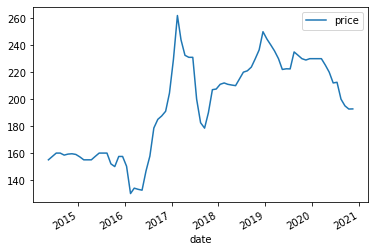

In [ ]:
diesel.plot()

In [ ]:
diesel['price'][:5]

date
2014-05-15    155.00
2014-07-15    160.00
2014-08-15    160.00
2014-09-15    158.50
2014-10-15    159.25
Name: price, dtype: float64

In [ ]:
price = diesel['price'].values.reshape(-1, 1)
price[:5]

array([[155.  ],
       [160.  ],
       [160.  ],
       [158.5 ],
       [159.25]])

In [ ]:
#initialize scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(price)

In [ ]:
#scale data
scaled_data = scaler.transform(price)
scaled_data[:5]

array([[-0.62121212],
       [-0.54545455],
       [-0.54545455],
       [-0.56818182],
       [-0.55681818]])

In [ ]:
scaled_data.shape

(77, 1)

To be able to predict with a neural network, data needs to be converted from time series to supervised learning.

This can be done by creating look back features from the data. Here, I used a lookback/ lag value of 1.

In [ ]:
#make into supervised learning data
data_with_lag = utils.timeseries_to_supervised(scaled_data)
data_with_lag.columns = ['lag_1', 'price']
data_with_lag.head()

,lag_1,price
0,0.000000,-0.621212
1,-0.621212,-0.545455
2,-0.545455,-0.545455
3,-0.545455,-0.568182
4,-0.568182,-0.556818


The model expects the input shape to be three-dimensional with 
`[samples, timesteps, features]`, therefore, we must reshape the single input sample before making the prediction.

In [ ]:
#separate into feature and target sets
X, y = utils.feature_target(data_with_lag)

In [ ]:
X[:5]

array([[[-0.62121212]],

       [[-0.54545455]],

       [[-0.54545455]],

       [[-0.56818182]],

       [[-0.55681818]]])

In [ ]:
y[:5]

array([[ 0.        ],
       [-0.62121212],
       [-0.54545455],
       [-0.54545455],
       [-0.56818182]])

In [ ]:
X.shape

(77, 1, 1)

Build LSTM Model

In [ ]:
model = utils.build_LSTM(X)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (1, 1, 50)                0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 100)                  60400     
_________________________________________________________________
dropout_1 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense (Dense)                (1, 1)                    101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
77/77 [==============================] - 3s 2ms/step - loss: 0.1538
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1060
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0397
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 8/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 11/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 12/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 13/100
77/77 [=================

Text(0.5, 1.0, 'Model Performance')

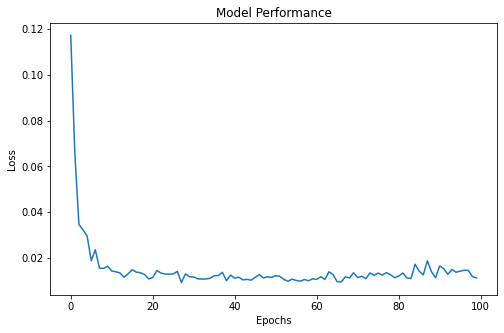

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Performance")

In [ ]:
y_pred = model.predict(X, batch_size=1)

In [ ]:
y_pred[:5]

array([[-0.30081007],
       [-0.47646174],
       [-0.5920146 ],
       [-0.66317904],
       [-0.6881618 ]], dtype=float32)

To check how well the model performed
- inverse transform the forecast for scaling (due to scaling that was done before model training)
- create a dataframe with the date, original price and the predicted price
- plot the data
- check metrics

In [ ]:
#inverse transform prediction to get predicted price
inverted_y_pred = scaler.inverse_transform(y_pred)
inverted_y_pred[:5]

array([[176.14653],
       [164.55353],
       [156.92705],
       [152.23018],
       [150.58131]], dtype=float32)

In [ ]:
df = pd.DataFrame()

df['date'] = diesel.index
df['price'] = list(diesel['price'])
df['predicted_price'] = inverted_y_pred
df.head()

,date,price,predicted_price
0,2014-05-15,155.00,176.146530
1,2014-07-15,160.00,164.553528
2,2014-08-15,160.00,156.927048
3,2014-09-15,158.50,152.230179
4,2014-10-15,159.25,150.581314


In [ ]:
print('MSE ', mean_squared_error(df['price'], df['predicted_price'])) #64

MSE  60.14873592763202


In [ ]:
#rmse
print('RMSE ', np.sqrt(mean_squared_error(df['price'], df['predicted_price'])))

RMSE  7.755561612651402


In [ ]:
print('R2 Score ', r2_score(df['price'], df['predicted_price']))

R2 Score  0.9503955577935074


MAPE SCORE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape = mean_absolute_percentage_error(df['price'], df['predicted_price'])

In [ ]:
mape

3.0109998048496442

In [ ]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

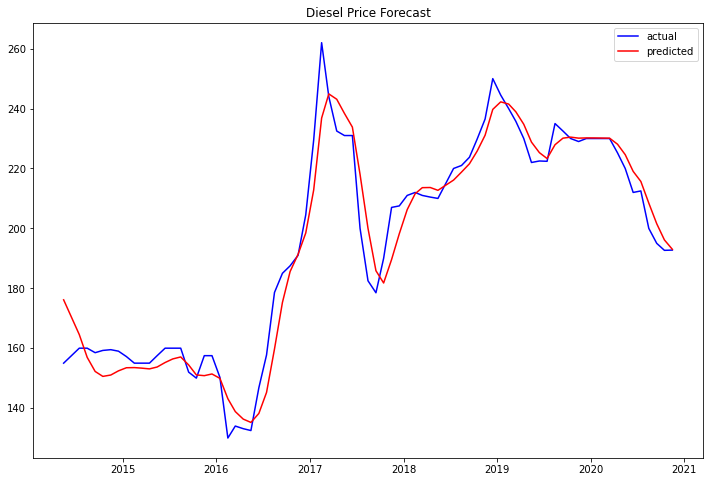

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df['price'], color="blue", label="actual")
plt.plot(df['predicted_price'], color="red", label="predicted")
plt.title("Diesel Price Forecast")
plt.legend()

The model performs really well on the exsiting dataset with an RMSE score of 9.44 and R2 Score of 92.64%.

I can confidently use this model to forecast future data.

## Future Prediction

I will be predicting diesel prices 3 years into the future, 2021, 2022, 2023. That is 36 months.

In [ ]:
#3 years, 36 months
num_prediction = 36

#past price data
price_data = scaler.transform([diesel['price']]).reshape(-1)
price_data[:5]

array([-0.62121212, -0.54545455, -0.54545455, -0.56818182, -0.55681818])

In [ ]:
price_data.shape

(77,)

In [ ]:
diesel.tail()

,price
date,
2020-07-15,212.5000
2020-08-15,200.0000
2020-09-15,195.0000
2020-10-15,192.6667
2020-11-15,192.7500


In [ ]:
#forecast future prices
forecast = utils.forecast(num_prediction, model, price_data, look_back=1)

forecast_dates = utils.forecast_dates(diesel, num_prediction, frequency = 'MS')

In [ ]:
forecast_dates[:5]

[Timestamp('2020-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'),
 Timestamp('2021-02-01 00:00:00', freq='MS'),
 Timestamp('2021-03-01 00:00:00', freq='MS'),
 Timestamp('2021-04-01 00:00:00', freq='MS')]

In [ ]:
forecast

array([-0.04924242, -0.06724228, -0.08096035, -0.09105455, -0.09987891,
       -0.10910337, -0.11988462, -0.13300169, -0.14897087, -0.1681408 ,
       -0.19076693, -0.21706554, -0.2472474 , -0.28152835, -0.32011709,
       -0.36316979, -0.41070896, -0.46249464, -0.51785433, -0.57549566,
       -0.63337708, -0.68875366, -0.73851162, -0.77977145, -0.81052989,
       -0.83001548, -0.83860379, -0.83744156, -0.82804841, -0.81206644,
       -0.79116619, -0.76704496, -0.7414524 , -0.71618629, -0.69303256,
       -0.67364049, -0.65936148])

In [ ]:
len(forecast_dates)

37

In [ ]:
#inverse transform forecast and reshape
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
forecast

array([[192.75      ],
       [191.56200954],
       [190.65661702],
       [189.99039961],
       [189.40799163],
       [188.7991773 ],
       [188.08761524],
       [187.22188878],
       [186.16792244],
       [184.90270728],
       [183.40938258],
       [181.67367417],
       [179.68167174],
       [177.41912866],
       [174.87227231],
       [172.03079391],
       [168.89320838],
       [165.47535366],
       [161.82161403],
       [158.01728642],
       [154.19711304],
       [150.54225814],
       [147.25823295],
       [144.53508449],
       [142.50502741],
       [141.21897829],
       [140.65214956],
       [140.7288568 ],
       [141.34880507],
       [142.40361524],
       [143.7830317 ],
       [145.37503254],
       [147.06414187],
       [148.73170519],
       [150.25985086],
       [151.53972769],
       [152.48214221]])

In [ ]:
len(forecast)

37

In [ ]:
future = pd.DataFrame()

future['date'] = list(forecast_dates)
future['predicted_price'] = forecast
future.set_index('date', inplace=True)
future.index = pd.to_datetime(future.index)
future.head()

,predicted_price
date,
2020-12-01,192.750000
2021-01-01,191.562010
2021-02-01,190.656617
2021-03-01,189.990400
2021-04-01,189.407992


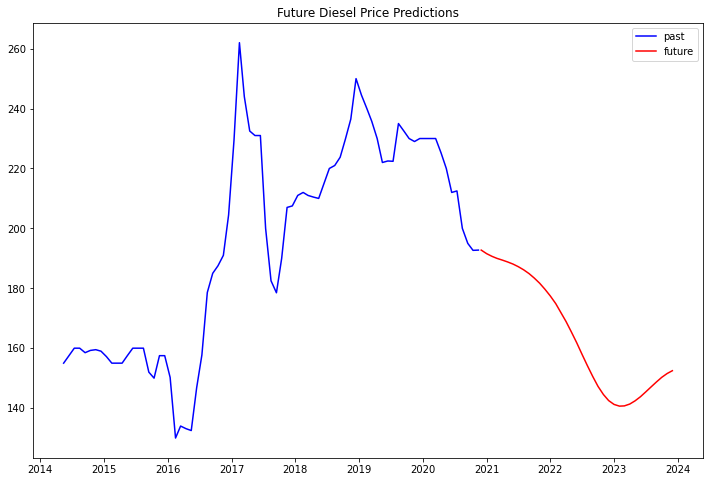

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(diesel ['price'], c='blue', label="past")
plt.plot(future['predicted_price'], c='red', label="future")
plt.title('Future Diesel Price Predictions')
plt.legend()

## Conclusion
The model performed really well on existing data with an r2 score of 94.58%.

The model has forecasted that diesel prices would reduce in 3 years time.

(but as a Nigerian living in Nigeria I do not believe this at all.)

## Recommendations 
I recommend changing the values of hyperparameters or compiling the model with different sets of optimizers such as Adam, SDG, etc., to see the change in the graph. 

You can also increase the layers in the LSTM network and check the results.

- optimizer
- activation function
- number of units
- add maxpooling etc
- more / less dropouts